In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

from src.dataframe import importDfPickle

import cv2
import os
import h5py
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

/home/eduardo/.local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df=importDfPickle("./output/breast_cancer_2000m.pkl")

In [3]:
df.head()

,label,image,path
0,1,"[[[222, 212, 239], [230, 224, 245], [235, 231,...",images/1/12867_idx5_x1851_y1351_class1.png
1,1,"[[[194, 170, 222], [188, 167, 219], [192, 171,...",images/1/16167_idx5_x2201_y1701_class1.png
2,1,"[[[160, 117, 172], [159, 127, 207], [158, 116,...",images/1/12821_idx5_x1651_y1551_class1.png
3,1,"[[[220, 204, 226], [229, 223, 241], [223, 205,...",images/1/13691_idx5_x3651_y1901_class1.png
4,1,"[[[169, 123, 176], [132, 86, 134], [136, 83, 1...",images/1/14154_idx5_x1801_y1501_class1.png


In [55]:
#df['tipo']=df['label'].apply(1,'Negativo')

In [56]:
#df['tipo']=df['label'].replace(0,'Positivo')

In [58]:
#

,label,image,path
0,Negativo,"[[[241, 240, 243], [241, 240, 243], [241, 240,...",images/0/10269_idx5_x1101_y901_class0.png
1,Negativo,"[[[200, 182, 232], [210, 193, 235], [220, 211,...",images/0/9254_idx5_x1551_y1851_class0.png
2,Negativo,"[[[206, 181, 227], [235, 230, 233], [238, 235,...",images/0/9259_idx5_x2401_y951_class0.png
3,Negativo,"[[[226, 210, 241], [235, 232, 241], [238, 232,...",images/0/12930_idx5_x951_y1201_class0.png
4,Negativo,"[[[242, 241, 241], [236, 236, 243], [150, 108,...",images/0/9227_idx5_x901_y1251_class0.png


In [4]:
X=np.asarray(list(df['image']))
X = X.reshape(X.shape[0], -1)
y=np.asarray(df['label'])

In [5]:
X.shape

(2000, 7500)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=70)

# fit the training data to the model
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
clf_pred = clf.predict(X_test)

In [21]:
clf.predict_proba(X_test)[0:10]

array([[0.88571429, 0.11428571],
       [0.27142857, 0.72857143],
       [0.88571429, 0.11428571],
       [0.37142857, 0.62857143],
       [0.98571429, 0.01428571],
       [0.81428571, 0.18571429],
       [0.08571429, 0.91428571],
       [0.9       , 0.1       ],
       [0.08571429, 0.91428571],
       [0.5       , 0.5       ]])

In [22]:
y_test[0:10]

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [23]:
clf_pred[0:10]

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0])

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("Mean Absolute Error is :", mean_absolute_error(y_test, clf_pred))
print('Mean Squared Error is :', mean_squared_error(y_test, clf_pred))
print('The R2 square value is :', r2_score(y_test, clf_pred)*100)

Mean Absolute Error is : 0.195
Mean Squared Error is : 0.195
The R2 square value is : 21.998049951248767


In [25]:
df_prueba = pd.DataFrame(list(zip(clf_pred , y_test)), 
               columns =['pred', 'lo que es']) 

In [26]:
df_prueba.head(10)

,pred,lo que es
0,0,0
1,1,1
2,0,0
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,1,1
9,0,0


In [27]:
import numpy as np
scores = pd.DataFrame({
    "predicted":clf_pred,
    "gt":y_test
})
scores["diff"] = np.abs(scores["predicted"]-scores["gt"])
scores["diff"].sum()/ len(y_test)

0.195

,gt,predicted,proba Beningno,proba Maligno
0,0,0,0.885714,0.114286
1,1,1,0.271429,0.728571
2,0,0,0.885714,0.114286
3,1,1,0.371429,0.628571
4,0,0,0.985714,0.014286


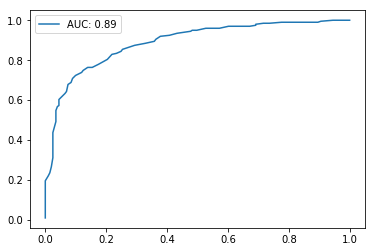

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
y_score = clf.predict_proba(X_test)

#print(y_score)
roc = roc_curve(y_test, y_score[:,1])
display(pd.DataFrame({
    "gt":y_test,
    "predicted":clf_pred,
    "proba Maligno":y_score[:,1],
    "proba Beningno":y_score[:,0]
}).head())

plt.plot(roc[0],roc[1])
plt.legend(["AUC: {}".format(round(roc_auc_score(y_test, y_score[:,1]),2))])


In [29]:
y_score

array([[0.88571429, 0.11428571],
       [0.27142857, 0.72857143],
       [0.88571429, 0.11428571],
       [0.37142857, 0.62857143],
       [0.98571429, 0.01428571],
       [0.81428571, 0.18571429],
       [0.08571429, 0.91428571],
       [0.9       , 0.1       ],
       [0.08571429, 0.91428571],
       [0.5       , 0.5       ],
       [0.21428571, 0.78571429],
       [0.92857143, 0.07142857],
       [0.9       , 0.1       ],
       [0.52857143, 0.47142857],
       [0.24285714, 0.75714286],
       [0.47142857, 0.52857143],
       [0.15714286, 0.84285714],
       [0.38571429, 0.61428571],
       [0.81428571, 0.18571429],
       [0.6       , 0.4       ],
       [0.41428571, 0.58571429],
       [0.62857143, 0.37142857],
       [0.74285714, 0.25714286],
       [0.38571429, 0.61428571],
       [0.74285714, 0.25714286],
       [0.08571429, 0.91428571],
       [0.7       , 0.3       ],
       [0.15714286, 0.84285714],
       [0.1       , 0.9       ],
       [0.34285714, 0.65714286],
       [0.